# 前言

这是一个着重于描述单比特操作和读取校准逻辑的文档。有关如何定义波形，如何自定义门的内容请阅读`qlisp`的相关文档。校准中使用的实验代码示例为`Scanner2`，其相关定义方式不在此赘述。使用任意实验方式均可，但校准逻辑不会有太大的变化。

另外，这是一个可以运行的`Notebook`但不建议在这个里面运行，这是出于对执行代码简洁性的考虑。

# 单比特校准的理论基础

## 驱动和操作过程

按照薛定谔方程的描述，量子态$|\psi(t)\rangle$的演化可以用演化算符$U(t)$来描述。

$$
i\frac{\partial}{\partial t}|\psi(t)\rangle=H|\psi(t)\rangle\\
|\psi'\rangle=U|\psi\rangle\\\notag
U(t)={\mathcal T}\exp\left[-i\int_0^tH(t'){\rm d}t'\right]
$$

实现任意操作的核心，在于构建适当的演化算符。在一个 two-level system (TLS) 中，任意的哈密顿量可以写为,

$$
H\equiv\begin{pmatrix}a+z&x-iy\\x+iy&a-z\end{pmatrix}=aI+xX+yY+zZ\\
I=\begin{pmatrix}1&\\&1\end{pmatrix}, X=\begin{pmatrix}&1\\1&\end{pmatrix}, Y=\begin{pmatrix}&-i\\i&\end{pmatrix}, Z=\begin{pmatrix}1&\\&-1\end{pmatrix}
$$

这等效于 Bloch 球上的旋转操作。Bloch球的定义见下文。

在我们的 transmon qubit 中，一般考虑其基态$|0\rangle$和第一激发态$|1\rangle$，矩阵表示为
$$
|0\rangle\equiv\begin{pmatrix}1\\0\end{pmatrix}, |1\rangle\equiv\begin{pmatrix}0\\1\end{pmatrix}
$$

对应能量$E_0$和$E_1$，则其哈密顿量可以写为

$$
H_0=E_0|0\rangle\langle0|+E_1|1\rangle\langle1|=\begin{pmatrix}E_0&\\&E_1\end{pmatrix}=\begin{pmatrix}\frac{E_0+E_1}2-\frac{E_1-E_0}2&\\&\frac{E_0+E_1}2+\frac{E_1-E_0}2\end{pmatrix}=-\frac\omega2Z+\frac{E_0+E_1}2I
$$

其中$\omega=E_1-E_0$，且忽略常数项后，得到

$$
H_0=-\frac\omega2Z
$$

若进入相互作用表象考虑，选定表象变换算符$\tilde U=e^{-iH_0t}$，

$$
|\psi_I\rangle=\tilde U|\psi_S\rangle\\
H_I=\tilde U^\dagger H_S\tilde U+i\frac{\partial \tilde U^\dagger}{\partial t}\tilde U=e^{iH_0t}H_0e^{-iH_0t}+i\left(\frac{\partial }{\partial t}e^{iH_0t}\right)e^{-iH_0t}=H_0+i\cdot iH_0\cdot e^{iH_0t}e^{-iH_0t}=H_0-H_0=0
$$

即，在相互作用表象下固有哈密顿量$H_0$的影响可以先不考虑。

> 这里有一个在表述上留下的“坑”，请格外注意。

实际操作往往通过给比特一个微波驱动来实现，其哈密顿量为

$$
\begin{aligned}
H'=\Omega e^{i(\omega_dt-\phi)}|0\rangle\langle1|+h.c.
&=\Omega\left(\left(\cos{(\omega_dt-\phi)}+i\sin{(\omega_dt-\phi)}\right)|0\rangle\langle1|+\left(\cos{(\omega_dt-\phi)}-i\sin{(\omega_dt-\phi)}\right)|1\rangle\langle0|\right)\\
&=\Omega\left(X\cos{(\omega_dt-\phi)}-Y\sin{(\omega_dt-\phi)}\right)
\end{aligned}
$$

此时，系统哈密顿量为$H=H_0+H'$，而在相互作用表象下，满足共振驱动条件$\omega_d=\omega$，且考虑旋波近似 (RWA)，

$$
H_I=\tilde U^\dagger H'\tilde U=\Omega\left(X\cos\phi+Y\sin\phi\right)
$$

那么此时的系统演化算符${\rm rfUnitary}(\theta, \phi)$，

$$
{\rm rfUnitary}(\theta, \phi)=e^{-i\frac\theta2\left(X\cos\phi+Y\sin\phi\right)}
$$

在这个演化过程中，$XY$-平面上的旋转轴$\phi$通过微波驱动的初相位来调控。而旋转的角度$\theta$则是需要校准的量，可以看出$\theta\propto \Omega t$，$\Omega$是耦合强度，也就是驱动微波的振幅，而$t$就是驱动微波时间，即驱动微波的包络下面积决定转动的角度。

一般通过标定$\theta=\pi/2$，得到一组演化算符

$$
{\rm R}(\phi)={\rm rfUnitary}(\pi/2, \phi)
$$

加上任意的相位操作，即${\rm P}(\phi)=|0\rangle\langle0|+e^{-i\phi}|1\rangle\langle1|$，可以组成任意的单比特上的酉操作。




## 读取过程

transmon在系统中和一个谐振腔通过电容耦合，耦合强度与频率失谐量近似满足色散耦合的条件，此时可以将其理解为：比特处在不同的态上，谐振腔的频率不同。通过探测这个频率变化带来的响应，可以实现量子态的区分。同时考虑到耦合形式，这个读取是量子非破坏性的 (QND) 的。

一般情况下，我们把一个频率为$\omega_r$的波包给到读取用谐振腔上，采集其透射或者反射的时域信号，记为$\rm Sig$，对应信号为`'trace_avg'`。

对此时域信号$\rm Sig$进行给定频率$\omega_r$的数字解模，得到其复IQ平面内的复振幅，记录为$S_{21}$，此读取方式记录为`iq`，按照测量次数对多个 shots 中的$S_{21}$作平均，得到的信号格式为`'iq_avg'`。

在同一个读取频率下，比特在$|0\rangle$和在$|1\rangle$时得到的$S_{21}$位于IQ平面的不同位置，考虑到噪声涨落，其表现为以不同点为中心的二维高斯分布。在IQ平面内进行区域判别，可以判断比特处于$|0\rangle$或者$|1\rangle$，此信号为`'state'`，即每一次shot都统计所有`cbit`对应的联合结果。对不同shots的态的测量进行统计，得到信号为`'count'`。若不关心不同的`'cbit'`的关联，可以进行单比特的概率计算，此信号为`'population'`，靠近1表示比特在$|1\rangle$的概率。

在部分设备下面，支持在采集AD端初步处理完数据再回传，所以这一类信号可以在对应的`signal`前加`'remote_'`前缀。

# 校准策略

我们的校准策略以拿到一块新样品为例，即，完全不知道样品的任何信息。这里的目的是校准出能用的单比特门，对于比特性质的表征，如$T_1$和$T_2$的测量不展开叙述。一些优化和继续提高的方法，特别是读取的优化，将会放在单比特进阶的文档中。

一般情况按照以下步骤进行：
1. 利用网分NA/采集卡AD做`S21`实验，找到比特$|0\rangle$时对应的腔频，将读取频率设置在此频率，跳转2.
2. 在`'iq_avg'`或者`'population'`信号下做比特的01`Spectrum`实验，得到可能得01驱动频率，跳转3.
3. 在`'iq_avg'`或者`'population'`信号下做比特的01`Ramsey`实验，确认频率是否正确，一般情况跳转4，否则回到2.
4. 在`'iq_avg'`或者`'population'`信号下做比特的01`PowerRabi`实验，若未实现 single shot 则跳转5，若为了校准drive则跳转6
5. 做01态判别的`Scatter`实验，两态可区分后`'population'`信号可用，若需要继续校准则一般跳转3.
6. 在`'population'`信号下做比特的01`Delta`实验，若找到则需要和步骤4来回迭代，直到达到理想精度

确认保真度则一般通过两个实验来实现
7. `'Count'`实验
8. `'RB'`实验

In [8]:
%matplotlib notebook

import numpy as np
from matplotlib import pyplot as plt

import kernel
# kernel.init()
from qos_tools.experiment.scanner2 import Scanner

from itertools import chain
from typing import Optional, Any, Union
from qos_tools.experiment.libs.tools import generate_spanlist
from home.hkxu.tools import get_record_by_id
from waveforms.visualization.widgets import DataPicker

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['figure.figsize'] = [9, 3]
plt.rcParams['font.size'] = 8
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
plt.rcParams['lines.marker'] = '.'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6

In [13]:
import time
from functools import lru_cache

default_shots = kernel.get('station.shots')
print(default_shots)

@lru_cache(maxsize=None)
def init_bias():
    ret = []
    return ret

@lru_cache(maxsize=None)
def fina_bias():
    ret = []
    return ret

def general_run_task(para_dict, timeout, print_task=True, bar=True, default_shots=default_shots, **kw):
    
    test = kernel.create_task(Scanner, args=(), kwds=para_dict['init'])
    test.init(**para_dict)
    test.shots = default_shots
    time.sleep(0.1)
    task = kernel.submit(test, **kw)
    if bar:
        task.bar()
    time.sleep(0.1)
    task.join(timeout)
    time.sleep(0.1)
    if print_task:
        print(task)
    return task

1024


## Measure

### `S21`

实验目标：测量

实验原理：

前置条件：无

获取结果



In [26]:
def S21(qubits: list[str],
                   center: Optional[Union[float, list[float]]] = None, delta: Optional[float] = None, st: Optional[float] = None, ed: Optional[float] = None, mode: str = 'linear', sweep_points: int = 101,
                   signal: str = 'iq_avg', repeat=1, **kw) -> dict:
    """
    [f'Q{i}'] Measure S21 without constraints, change awg frequency.

    Args:
        qubits (list[str]): qubit names.
        center (Optional[Union[float, list[float]]], optional): sweep center. Defaults to None.
        delta (Optional[float], optional): sweep span. Defaults to None.
        st (Optional[float], optional): sweep start. Defaults to None.
        ed (Optional[float], optional): sweep end. Defaults to None.
        sweep_points (int, optional): sweep points. Defaults to 101.
        mode (str, optional): sweep mode. Defaults to 'linear'.
        signal (str, optional): signal. Defaults to 'iq_avg'.
    """
    
    cts = {q: kernel.get(f'gate.Measure.{q}.default_type') for q in qubits}
    cts = {q: 'params' if cts[q]=='default' else cts[q] for q in qubits}

    if center is None:
        center = [kernel.get(
            f'gate.Measure.{q}.{cts[q]}.frequency') for q in qubits]
        
    elif isinstance(center, float):
        center = [center]*len(qubits)

    sweep_list = generate_spanlist(
        center=0, delta=delta, st=st, ed=ed, sweep_points=sweep_points, mode=mode)

    return {
        'init': {
            'name': 'S21',
            'qubits': qubits,
            'signal': signal,
        },
        'setting': {
            'circuit':
            init_bias()+
            [
                ('Barrier', tuple(qubits)),
                (('Delay', 2e-6), qubits[0]),
                ('Barrier', tuple(qubits)),
                *[(('Measure', j), q) for j, q in enumerate(qubits)],
            ]
            +fina_bias()
            ,
        },
        'sweep_config': {
            q: {
                'addr': f'gate.Measure.{q}.{cts[q]}.frequency',
            }
            for q in qubits
        },
        'sweep_setting': {
#             'repeat': np.arange(repeat),
            tuple(qubits): tuple([
                sweep_list + center[j]
                for j, i in enumerate(qubits)
            ]),
        },
    }

In [27]:
qubits = ['Q0', 'Q11']

st, ed, sweep_points, signal = -1e6,1e6, 31, 'remote_iq_avg'

para_dict = S21(qubits=qubits, st=st, ed=ed, sweep_points=sweep_points, mode='log', signal=signal)

In [17]:
task = general_run_task(para_dict, 1800, dry_run=True, bar=False)

S21(11093862863540805035, record_id=183814)


<IPython.core.display.Javascript object>


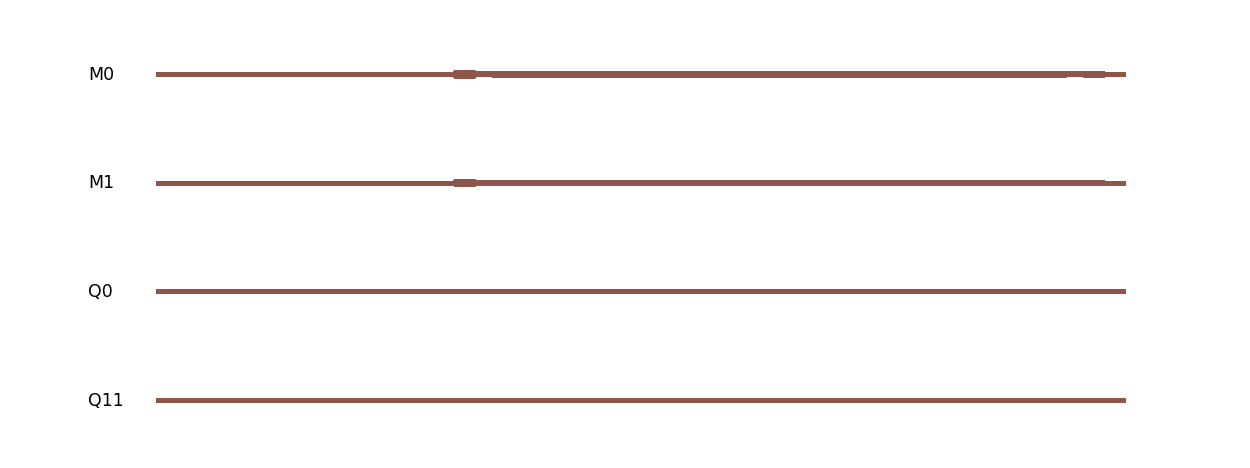

In [25]:
task.plot_prog_frame(0, start=0e-6, stop=6.5e-6, raw=True, sample_rate=6e9, keys=['M0', 'M1', 'Q0', 'Q11'])

In [ ]:
result = task.result()

fig, ax = plt.subplots((len(qubits)+4)//5, 5, figsize=[8, (len(qubits)+4)//5*1.6])
ax = ax.flatten()
fig.suptitle(f"{task.name} id={task.record_id}")

from qos_tools.analyzer.tools import get_normalization, get_convolve_arg

cali = {}

for i, q in enumerate(qubits):
    flag, ans = get_convolve_arg(x=result['index'][q][:], y=np.abs(result[signal][:, i]), 
                                 ax=ax[i], ext='min')
    if flag:
        ax[i].axvline(x=result['index'][q][np.argmin(get_normalization(np.abs(result[signal][:, i])))], c='k', ls='--')
#         cali[f'gate.Measure.{q}.params.frequency'] = result['index'][q][np.argmin(get_normalization(np.abs(result[signal][:, i])))]
        cali[f'gate.Measure.{q}.params.frequency'] = ans
#     ax[i].plot(result['index'][q][:], (np.abs(result[signal][:, i]))/1e8, '.-')
#     cali[f'gate.Measure.{q}.params.frequency'] = result['index'][q][np.argmin(np.abs(result[signal][:, i]))]
#     ax[i].axvline(x=cali[f'gate.Measure.{q}.params.frequency'], c='r')
    ax[i].set_title(q, fontsize=8)
        
fig.tight_layout()
fig.show()

In [ ]:
kernel.update_parameters(cali)
plt.close('all')

## R